# Partial Differential Equations
Solving PDES could demand too much resource compared to other types of computational  
problems (ODE). Number of points required to discretize a region of space scale exponentially  
with the number of dimension (1D, 2D, 3D).  

We have library like FEniCS to perform those complex tasks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.mplot3d

import scipy.sparse as sp
import scipy.sparse.linalg
import scipy.linalg as la

import dolfinx
import ufl

### Finite Difference Methods
Forward difference formula du(xn)/dx = (u(xn+1) - u(xn))/(xn+1 - xn)  
Backward difference formula du(xn)/dx = (u(xn) - u(xn-1))/(xn+1 - xn-1)  
Second order derivative d2u(xn)/dx2 = (u(xn+1) - 2u(xn) + u(xn-1))/(xn - xn-1)2  
An ODE problem uxx = -5 in the interval x element of [0,1]  
u(x=0) = 1 and u(x=1) = 2.  
This problem can be formulated as Au = b

In [2]:
N = 5
u0, u1 = 1, 2
dx = 1.0/(N+1)
A = (np.eye(N, k=-1) - 2*np.eye(N) + np.eye(N, k=1)) / dx**2
A

array([[-72.,  36.,   0.,   0.,   0.],
       [ 36., -72.,  36.,   0.,   0.],
       [  0.,  36., -72.,  36.,   0.],
       [  0.,   0.,  36., -72.,  36.],
       [  0.,   0.,   0.,  36., -72.]])

In [3]:
b = -5*np.ones(N)
b[0] -= u0 / dx**2
b[N-1] -= u1 / dx**2
b

array([-41.,  -5.,  -5.,  -5., -77.])

In [4]:
u = la.solve(A, b)
u

array([1.51388889, 1.88888889, 2.125     , 2.22222222, 2.18055556])

Text(0, 0.5, '$u(x)$')

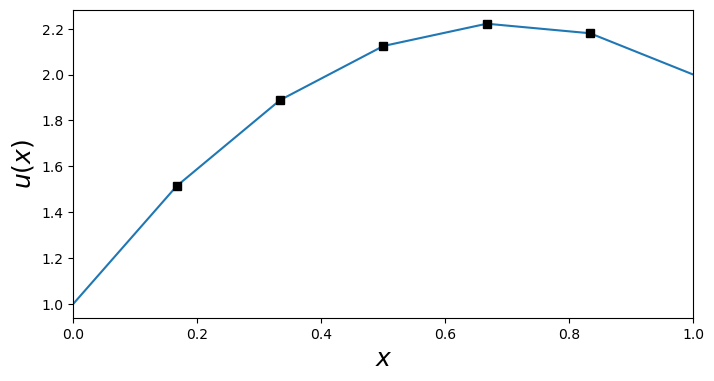

In [5]:
X = np.linspace(0, 1, N+2)
# U combines the boundary values and the interior points in one array
U = np.hstack([[u0], u, [u1]])
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(X, U)
ax.plot(X[1:-1], u, 'ks')
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$u(x)$", fontsize=18)

A 2D problem: uxx + uyy = 0 with bc  
u(x=0) = 3, u(x=1)=-1, u(y=0)=-5 and u(y=1)=5

In [6]:
N = 100
u0_t, u0_b = 5, -5
u0_l, u0_r = 3, -1
dx = 1./(N+1)
# One dim formula along x axis
A1_d = (sp.eye(N, k=-1) + sp.eye(N, k=1) - 4 *sp.eye(N)) / dx**2
A = sp.kron(sp.eye(N), A1_d) + (sp.eye(N**2, k=-N) + sp.eye(N**2, k=N)) / dx**2
A

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 49600 stored elements in Compressed Sparse Row format>

- To construct the vector `b` from the boundary conditions, it is convenient to create a NxN  
array of nonzeros, and assign the boundary condition to edge element of this array.  
Then we can reshape this matrix to N**2x1 vector that can be used in the Au = b

In [7]:
b = np.zeros((N, N))
b[0, :] += u0_b # bottom
b[-1, :] += u0_t # top
b[:, 0] += u0_l # left
b[:, -1] += u0_r # right
b = -b.reshape(N**2) / dx**2
b

array([ 20402.,  51005.,  51005., ..., -51005., -51005., -40804.])

### Solving Equation

In [8]:
v = sp.linalg.spsolve(A, b)
u = v.reshape(N, N)

### Visualization

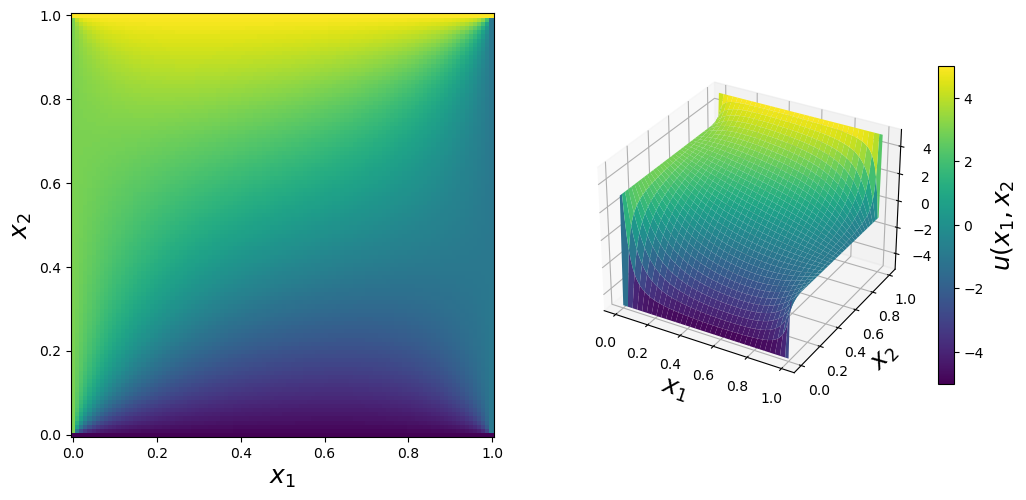

In [9]:
U = np.vstack([np.ones((1, N+2)) * u0_b,
                np.hstack([np.ones((N, 1)) * u0_l, u, np.ones((N, 1)) * u0_r]),
                np.ones((1, N+2))*u0_t])
x = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)
fig = plt.figure(figsize=(12, 5.5))
cmap = mpl.cm.get_cmap('viridis')
ax = fig.add_subplot(1, 2, 1)
c = ax.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=cmap)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)

ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, U, vmin=-5, vmax=5, rstride=3, cstride=3,
                    linewidth=0, cmap=cmap)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb = plt.colorbar(p, ax=ax, shrink=0.75)
cb.set_label(r"$u(x_1, x_2$", fontsize=18)

Solution to the two dimensional heat equation with Dirichlet boundary conditions defined in the text

- FDM methods result in matrices `A`  that are very sparse. Using sparse matrix can give significant performance improvement  


In [10]:
x.shape

(102,)

In [11]:
A_dense = A.todense()
%timeit la.solve(A_dense, b)

11.9 s ± 589 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit sp.linalg.spsolve(A,b)

40.9 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## FEM
To Solve a FEM problem, we perform next steps:
- Generate a Mesh for the problem domain
- Write the PDE on weak form
- Program the problem in the FEM framework
- Solve the resulting algebraic equations
- Post process and/or visulize the solution

In [2]:
import sys
import gmsh
from dolfinx.io import XDMFFile, gmshio
from mpi4py import MPI
import dolfinx 

from ufl import (TestFunction, SpatialCoordinate, TrialFunction,
                as_vector, dx, grad, inner, system)
import numpy as np
from petsc4py import PETSc
import matplotlib.pyplot as plt

import pyvista

### Mesh generation

In [3]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)
model = gmsh.model()
model.add("Rectangle")
model.setCurrent("Rectangle")
length = 10
height = 3
rectangle = model.occ.addRectangle(0,0,0,length,height)
model.occ.synchronize()
model.addPhysicalGroup(1, [1])
model.addPhysicalGroup(2, [rectangle])
ov = gmsh.model.getEntitiesInBoundingBox(0,0,0,length,height, 0)
gmsh.model.mesh.setSize(ov, 0.5)
model.mesh.generate(3)

### Export mesh to dolfinx format

In [4]:
domain, cell_markers, facet_markers = gmshio.model_to_mesh(model, MPI.COMM_SELF, 0)
domain.name = "Rectangle"
cell_markers.name = f"{domain.name}_cells"
facet_markers.name = f"{domain.name}_facets"

gmsh.finalize()

### Creation of two subdomains

In [5]:
def concrete(x):
    return x[0] >= length/2

def layer_1(x):
    return x[0] <= length/2
Q = dolfinx.fem.FunctionSpace(domain, ("DG", 0))
kappa =   dolfinx.fem.Function(Q)
cells_0 = dolfinx.mesh.locate_entities(domain, domain.topology.dim, concrete)
cells_1 = dolfinx.mesh.locate_entities(domain, domain.topology.dim, layer_1)

kappa.x.array[cells_0] = np.full_like(cells_0, 0.54, dtype=PETSc.ScalarType)
kappa.x.array[cells_1] = np.full_like(cells_1, 1, dtype=PETSc.ScalarType)


### PDE on weak form

In [6]:
V = dolfinx.fem.FunctionSpace(domain, ("Lagrange", 1))
u = TrialFunction(V)
v = TestFunction(V)
un  = dolfinx.fem.Function(V)
f = dolfinx.fem.Constant(domain, 0.0)
mu = dolfinx.fem.Constant(domain, 2.3)
dt = dolfinx.fem.Constant(domain, 0.05)

F = inner(u - un, v) * dx + dt * mu * inner(kappa*grad(u), grad(v)) * dx
F -= dt * inner(f,v) * dx
(a, L) =  system(F)

### Dirichlet Boundary Condtions


In [7]:
# This is for exanmple temperature input profile
def uD_function(t):
    return lambda x: x[0]*0 + 25

uD = dolfinx.fem.Function(V)
t = 0
uD.interpolate(uD_function(t))

# Boundaries
def dirichlet_facets(x):
    return np.isclose(x[0], length)

tdim = domain.topology.dim
bc_facets = dolfinx.mesh.locate_entities_boundary(domain, tdim - 1, dirichlet_facets)
bndry_dofs = dolfinx.fem.locate_dofs_topological(V, tdim - 1, bc_facets)
bcs = [dolfinx.fem.dirichletbc(uD, bndry_dofs)]

### Applying boundary conditions on time LHS

In [8]:
compiled_a = dolfinx.fem.form(a)
A = dolfinx.fem.petsc.assemble_matrix(compiled_a, bcs=bcs)
A.assemble()

comipled_L = dolfinx.fem.form(L)
b = dolfinx.fem.Function(V)

### Solver for time dependant problem

PETSc: Portable, Extensible Toolkit for Scientific Computation  
We create a  Krylov Subspace Method solver for the domain and set the type of solver to Conjugate Gradients.  
The preconditioner is set to HYPRE (High Performance Preconditioners)


In [9]:
# PETSc
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.CG)

pc =  solver.getPC()
pc.setType(PETSc.PC.Type.HYPRE)
pc.setHYPREType("boomeramg")

## Resolution and visualization

In [10]:
plotter_2 = pyvista.Plotter()
plotter_2.open_gif("u_time.gif")
topology_2, cells_2, geometry_2 = dolfinx.plot.create_vtk_mesh(V)
uh = dolfinx.fem.Function(V)
grid_2 = pyvista.UnstructuredGrid(topology_2, cells_2, geometry_2)
grid_2.point_data["T"] = uh.x.array
viridis  = plt.cm.get_cmap("viridis", 25)
sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="white" ,
                position_x=0.1, position_y=0.8, width=0.8, height=0.1)

renderer = plotter_2.add_mesh(grid_2, show_edges=True, lighting=False,
                                cmap=viridis, scalar_bar_args=sargs, clim=[0, 30])
plotter_2.view_xy()
plotter_2.camera.zoom(1.3)

# Solving a time dependent problem
T = 20
while t < T:
    # Update boundary condition
    t += dt.value
    uD.interpolate(uD_function(t))

    # Assemble RHS
    b.x.array[:] = 0
    dolfinx.fem.petsc.assemble_vector(b.vector, comipled_L)

    # Apply boundary condition
    dolfinx.fem.petsc.apply_lifting(b.vector, [compiled_a], [bcs])
    b.x.scatter_reverse(dolfinx.la.ScatterMode.add)
    dolfinx.fem.petsc.set_bc(b.vector, bcs)

    # Solve linear problem
    sol_u = solver.solve(b.vector, uh.vector)
    uh.x.scatter_forward()

    # Update un
    un.x.array[:] = uh.x.array

    # Update plotter
    plotter_2.update_scalars(uh.x.array, render=False)
    plotter_2.write_frame()

plotter_2.close()

In [14]:
np.info(dolfinx.fem.petsc.assemble_vector)

 assemble_vector(L: 'typing.Any', constants=None, coeffs=None) -> 'PETSc.Vec'

None


: 

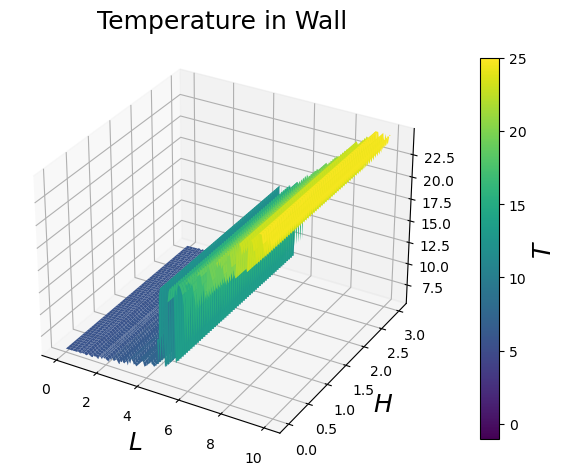

In [56]:
import matplotlib.pyplot as plt
import matplotlib as mpl

sol_u, _ = np.meshgrid(uh.x.array, b.x.array)
l = np.linspace(0, length, uh.x.array.shape[0])
h = np.linspace(0, height, uh.x.array.shape[0])

L, H = np.meshgrid(l, h)

fig = plt.figure(figsize=(12, 5.5))
cmap = mpl.cm.get_cmap('viridis')

ax = fig.add_subplot(1,1,1, projection='3d')
p = ax.plot_surface(L, H, sol_u, vmin=-1, vmax=25, rstride=3, cstride=3,
                    linewidth=0, cmap=cmap)
ax.set_xlabel(r"$L$", fontsize=18)
ax.set_ylabel(r"$H$", fontsize=18)
ax.set_title(r"Temperature in Wall", fontsize=18)
cb = plt.colorbar(p, ax=ax, shrink=0.9)
cb.set_label(r"$T$", fontsize=18)



NameError: name 'b' is not defined